In [10]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

df = pd.read_csv('data/K120.csv', delimiter=';').to_numpy()
data = np.array(df[:, 1:], dtype=float)
data = np.nan_to_num(data, 0)

In [11]:
#https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing#scrollTo=bY2yEu2QTBXP
def df_to_X_y(data, window_size=5):
  X = []
  y = []
  for i in range(len(data)-window_size):
    row = [[a] for a in data[i:i+window_size]]
    X.append(row)
    label = data[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

#split and normalize the data
window_size = 10
X, Y = df_to_X_y(data, window_size=window_size)
X.shape

(2870, 10, 1, 10)

In [34]:
num_of_steps = data.shape[0]
train_size = 0.5
val_size = 0.2

num_train = int(num_of_steps * train_size)
num_val = int(num_of_steps * val_size)

train_set = data[:num_train]
mean, std = np.nanmean(train_set, axis=0), np.nanstd(train_set, axis=0)

# train_set = (train_set - mean) / std
# val_set = (data[num_train:num_train + num_val] - mean) / std
# test_set = (data[num_train + num_val:] - mean) / std

train_set = train_set
val_set = data[num_train:num_train + num_val]
test_set = data[num_train + num_val:]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(1440, 10)
(576, 10)
(864, 10)


In [35]:
from keras.utils import timeseries_dataset_from_array

#inputs series of sequential inputs


#targets, depending on the forecast horizon and if we want to return multiples a

batch_size = 32
input_sequence_length = 8
forecast_horizon = 1
multi_horizon = False

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=False,
):
    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_set, val_set]
)

test_dataset = create_tf_dataset(
    test_set,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_set.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


In [36]:
list(train_dataset.as_numpy_iterator())

[(array([[[[ 7.],
           [ 5.],
           [ 4.],
           ...,
           [12.],
           [ 6.],
           [ 6.]],
  
          [[ 6.],
           [ 3.],
           [ 4.],
           ...,
           [20.],
           [ 3.],
           [ 0.]],
  
          [[ 8.],
           [ 2.],
           [ 4.],
           ...,
           [15.],
           [ 3.],
           [ 4.]],
  
          ...,
  
          [[ 3.],
           [ 1.],
           [ 2.],
           ...,
           [ 9.],
           [ 2.],
           [ 2.]],
  
          [[ 2.],
           [ 0.],
           [ 4.],
           ...,
           [17.],
           [ 1.],
           [ 0.]],
  
          [[ 3.],
           [ 0.],
           [ 0.],
           ...,
           [ 4.],
           [ 4.],
           [ 1.]]],
  
  
         [[[ 6.],
           [ 3.],
           [ 4.],
           ...,
           [20.],
           [ 3.],
           [ 0.]],
  
          [[ 8.],
           [ 2.],
           [ 4.],
           ...,
           [

In [37]:
import keras.layers

batch_size = 32
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = data.shape[1]

units = 64
output_size = data.shape[1]  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [41]:
from keras.losses import *
from keras.optimizers import Adam
model = build_model()
model.summary()
model.compile(
    loss=MeanAbsoluteError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)
results = model.predict(test_dataset)
print(results[:10])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                19200     
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 19,850
Trainable params: 19,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
45/45 [==============================] - 3s 25ms/step - loss: 28.7371 - accuracy: 0.0133 - val_loss: 27.0687 - val_accuracy: 0.0141
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 28.5074 - accuracy: 0.0098 - val_loss: 26.8484 - val_accuracy: 0.0106
Epoch 3/100
45/45 [==============================] - 0s 8ms/step - loss: 28.2974 - accuracy: 0.0182 - val_loss: 26.6338 - val_accuracy: 0.0158
Epoch 4/100
45/4

-0.07067995


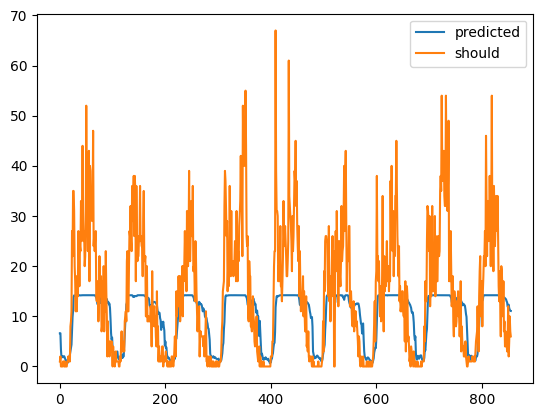

In [42]:
print(np.min(results))
y = np.concatenate([y for x, y in test_dataset], axis=0)
plt.plot(results[:, 0], label='predicted')
plt.plot(y[:,0,0], label='should')
plt.legend()
plt.show()

In [30]:
y.shape, results.shape

((856, 1, 10), (856, 10))